# Import modules

In [1]:
import os
import json
import pandas as pd
import numpy as np       
import seaborn as sbn
%matplotlib inline

# Read in data

In [2]:
MOJO_DIR = os.path.join('..','project_1','data', 'boxofficemojo')
META_DIR = os.path.join('..','project_1','data', 'metacritic')

In [3]:
def load_movie_data():
    movie_list_mojo=[]
    movie_list_meta=[]

    for file1 in os.listdir(MOJO_DIR):
        path=os.path.join(MOJO_DIR,file1)
        with open(path, 'r') as target_file:
            movie = json.load(target_file)
            movie_list_mojo.append(movie)

    for file1 in os.listdir(META_DIR):
        if '_parsed' in str(file1):
            path=os.path.join(META_DIR,file1)
            with open(path, 'r') as target_file:
                movie = json.load(target_file)
                movie_list_meta.append(movie)
    
    return movie_list_mojo,movie_list_meta

mojo,meta=load_movie_data()[0],load_movie_data()[1]



for i in meta:
    i['num_critic_reviews']=str(i['num_critic_reviews'])
    i['num_user_reviews']=str(i['num_user_reviews'])

meta_df=pd.DataFrame(meta)
mojo_df=pd.DataFrame(mojo)

both_df=pd.merge(mojo_df,meta_df, on='title',how='left')

# Calculate rolling mean
## Rolling mean the mean gross amount for all movies directed by the director prior to the release date

In [4]:
derived_dt=pd.DataFrame()
#Get the mean gross amount for all movies directed by the director prior to the release date. This only returns all 
#observations where director is not missing
both_df['release_date_wide']=pd.to_datetime(both_df['release_date_wide'])
movie_by_drt=both_df.groupby('director_x')

for i in movie_by_drt:
    if len(i[1])>1:
        df=i[1].copy()
        df.sort_values('release_date_wide',ascending=False,inplace=True)
        df.reset_index(drop=True,inplace=True)
        #q=df.index.values
        df['rolling_mean']=np.nan
        for z in range(0,(len(df)-1)):
            df.ix[z,'rolling_mean']= df.ix[(z+1):,'domestic_gross'].mean()
    else:
        df=i[1].copy()
        #break
    try:
        derived_dt=pd.concat([derived_dt,df])
    except:
        derived_dt=df

In [5]:
# Concatenate with the obsversations where director is miss
both_df=pd.concat([derived_dt,both_df[both_df.director_x.isnull()==True]],axis=0)

# Create genre dummy

In [6]:
genre_list = []
for genre in both_df['genre']:
    if type(genre)== list:
        for sub_genre in genre:
            genre_list.append(sub_genre)
    else:
        genre_list.append(genre)

genre_list_pd = pd.Series(genre_list)

In [7]:
def gtype(x, genre_type):
    if type(x) ==list:
        if genre_type in x:
            return(1)
        else:
            return(0)
    else:
        return(0)

for genre_type in genre_list_pd:
    both_df[genre_type]=[gtype(entry,genre_type) for entry in both_df['genre']]

# Build linear model

In [8]:
import statsmodels.formula.api as smf

## 1.1 Clean variables

In [9]:
missing_count=both_df.isnull().sum()
dependent_variable=list(missing_count[missing_count<500].index)

In [10]:
column_to_rm=['domestic_gross','mojo_slug','opening_weekend_take','title',np.nan,'Adult','News','','alt_title']
for col in column_to_rm:
    dependent_variable.remove(col)

In [11]:
both_df['year_to_date']=2016-both_df['year_x']
dependent_variable.remove('year_x')
dependent_variable.append('year_to_date')
dependent_variable.append('runtime_minutes')

In [14]:
dependent_variable.append('rolling_mean')

In [15]:
buildX=both_df[dependent_variable]
def missing_indicator(x):
    if np.isnan(x):
        return(1)
    else:
        return(0)
buildX['open_per_theater_missing']=map(missing_indicator,buildX['opening_per_theater'])
buildX['widest_release_MI']=map(missing_indicator,buildX['widest_release'])
buildX['runtime_minutes_MI']=map(missing_indicator,buildX['runtime_minutes'])
buildX['year_to_date_MI']=map(missing_indicator,buildX['year_to_date'])
buildX['rolling_mean_MI']=map(missing_indicator,buildX['rolling_mean'])

/Users/ypj173/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ypj173/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ypj173/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable

In [16]:
buildX.fillna(buildX.median(),inplace=True)

/Users/ypj173/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:3178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,opening_per_theater,release_date_wide,widest_release,Drama,Mystery,Thriller,Horror,Comedy,Romance,Adventure,...,Sport,War,year_to_date,runtime_minutes,rolling_mean,open_per_theater_missing,widest_release_MI,runtime_minutes_MI,year_to_date_MI,rolling_mean_MI
1458,6485.0,2006-10-13,3214.0,1,1,1,1,0,0,0,...,0,0,10.0,102.0,43285751.5,0,0,0,0,1
865,6587.0,2006-02-17,2898.0,0,0,0,0,1,1,0,...,0,0,10.0,83.0,43285751.5,0,0,0,0,1
968,1984.0,2011-10-07,10.0,1,0,0,0,0,0,0,...,0,0,5.0,90.0,43285751.5,0,0,0,0,1
51,2785.0,2012-03-23,3.0,0,0,0,0,0,0,0,...,0,0,4.0,104.0,43285751.5,0,0,1,0,1
913,4430.0,2008-02-14,2220.0,1,0,0,0,1,1,0,...,0,0,8.0,112.0,43285751.5,0,0,0,0,1
0,7480.0,2013-12-18,3507.0,0,0,0,0,0,0,0,...,0,0,3.0,104.0,111323491.0,0,0,1,0,0
1,10000.0,2008-07-25,3182.0,0,0,0,0,1,0,0,...,0,0,8.0,98.0,116750840.0,0,0,0,0,0
2,12369.0,2006-08-04,3807.0,0,0,0,0,0,0,0,...,0,0,10.0,104.0,85288303.0,0,0,1,0,0
3,9193.0,2004-07-09,3104.0,0,0,0,0,0,0,0,...,0,0,12.0,104.0,43285751.5,0,0,1,0,1
934,1112.0,1999-08-13,1802.0,0,0,0,0,1,0,1,...,0,0,17.0,95.0,43285751.5,0,0,0,0,1


In [17]:
buildX['domestic_gross']=both_df['domestic_gross']

/Users/ypj173/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [18]:
buildX=buildX.dropna()

## 1.2 Derive month of release

In [19]:
buildX['release_date_wide']=pd.to_datetime(buildX['release_date_wide'])

buildX['release_month']=map(lambda x:x.month,buildX['release_date_wide'])

month=range(1,13)

def r_month(x, month):
    if x == month:
        return(1)
    else:
        return(0)

for release_month in month:
    dummy_v='month'+str(release_month)
    buildX[dummy_v]=[r_month(entry,release_month) for entry in buildX['release_month']]


/Users/ypj173/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/ypj173/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/ypj173/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

## Full model

In [20]:
formula='domestic_gross~opening_per_theater+widest_release+Drama+Mystery+Thriller+Horror+Comedy+Romance\
+Adventure+Music+Musical+Fantasy+Family+Action+Crime+Western+History+Biography+Documentary+Animation+Sport+War\
+year_to_date+open_per_theater_missing+widest_release_MI+runtime_minutes_MI+year_to_date_MI+rolling_mean_MI+rolling_mean\
+runtime_minutes+month1+month2+month3+month4+month5+month6+month7+month8+month9+month10+month11'
full_model=smf.ols(formula,data=buildX)
full_model=full_model.fit()

In [21]:
full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         domestic_gross   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     121.7
Date:                Thu, 30 Jun 2016   Prob (F-statistic):               0.00
Time:                        23:24:01   Log-Likelihood:                -69079.
No. Observations:                3666   AIC:                         1.382e+05
Df Residuals:                    3625   BIC:                         1.385e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept                -7.176e+07   6.27e+06    -11.448      0.000      -8.4e+07 -5.95e+07
opening_per_theater       1369.1891     77.992     17.556      0.000      1216.277  1522.101
widest_release            2.544e+04    624.447     40.743      0.000      2.42e+04  2.67e+04
Drama                     1.848e+06   1.87e+06      0.990      0.322     -1.81e+06  5.51e+06
Mystery                  -2.843e+06   2.82e+06     -1.009      0.313     -8.37e+06  2.68e+06
Thriller                 -9.967e+05   2.18e+06     -0.456      0.648     -5.28e+06  3.28e+06
Horror                   -3.446e+06   3.06e+06     -1.125      0.261     -9.45e+06  2.56e+06
Comedy                    1.861e+06   1.96e+06      0.948      0.343     -1.99e+06  5.71e+06
Romance                  -2.404e+06   2.05e+06     -1.171      0.242     -6.43e+06  1.62e+06
Adventure                 9.299e+06   2.71e+06      3.427      0.001      3.98e+06  1.46e+07
Music                    -6.984e+06   4.44e+06     -1.572      0.116     -1.57e+07  1.72e+06
Musical                   3.219e+06   6.14e+06      0.525      0.600     -8.81e+06  1.52e+07
Fantasy                  -2.478e+05   2.82e+06     -0.088      0.930     -5.77e+06  5.28e+06
Family                   -7.159e+05    3.5e+06     -0.204      0.838     -7.58e+06  6.15e+06
Action                    9.685e+05   2.42e+06      0.401      0.689     -3.77e+06  5.71e+06
Crime                    -3.924e+05   2.29e+06     -0.171      0.864     -4.88e+06   4.1e+06
Western                  -7.789e+06   7.03e+06     -1.107      0.268     -2.16e+07     6e+06
History                  -2.921e+06   4.12e+06     -0.708      0.479      -1.1e+07  5.16e+06
Biography                -2.113e+06   3.42e+06     -0.618      0.537     -8.82e+06  4.59e+06
Documentary               6.094e+06    3.9e+06      1.563      0.118     -1.55e+06  1.37e+07
Animation                 2.552e+07   4.44e+06      5.746      0.000      1.68e+07  3.42e+07
Sport                    -7.641e+06   4.46e+06     -1.714      0.087     -1.64e+07   1.1e+06
War                      -7.524e+06   4.02e+06     -1.874      0.061     -1.54e+07  3.49e+05
year_to_date              1.034e+06   8.93e+04     11.580      0.000      8.59e+05  1.21e+06
open_per_theater_missing  8.581e+06   4.92e+06      1.743      0.081     -1.07e+06  1.82e+07
widest_release_MI        -2.853e+07   6.04e+06     -4.719      0.000     -4.04e+07 -1.67e+07
runtime_minutes_MI       -3.133e+06   2.48e+06     -1.261      0.207        -8e+06  1.74e+06
year_to_date_MI             -0.0004      0.000     -2.468      0.014        -0.001 -8.84e-05
rolling_mean_MI           9.711e+04   1.47e+06      0.066      0.947     -2.79e+06  2.99e+06
rolling_mean                 0.2076      0.021      9.691      0.000         0.166     0.250
runtime_minute

In [22]:
formula_months='domestic_gross~month1+month2+month3+month4+month5+month6+month7+month8+month9+month10+month11'
model_month=smf.ols(formula_months,data=buildX)
model_month=model_month.fit()

In [23]:
model_month.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         domestic_gross   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     20.85
Date:                Thu, 30 Jun 2016   Prob (F-statistic):           1.38e-41
Time:                        23:24:26   Log-Likelihood:                -70528.
No. Observations:                3666   AIC:                         1.411e+05
Df Residuals:                    3654   BIC:                         1.412e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   5.861e+07   3.31e+06     17.703      0.000      5.21e+07  6.51e+07
month1     -2.823e+07   4.63e+06     -6.099      0.000     -3.73e+07 -1.92e+07
month2     -2.888e+07   4.64e+06     -6.222      0.000      -3.8e+07 -1.98e+07
month3     -2.665e+07   4.51e+06     -5.908      0.000     -3.55e+07 -1.78e+07
month4     -3.665e+07   4.51e+06     -8.126      0.000     -4.55e+07 -2.78e+07
month5     -1.212e+07   4.78e+06     -2.536      0.011     -2.15e+07 -2.75e+06
month6      1.005e+06   4.61e+06      0.218      0.827     -8.03e+06     1e+07
month7     -6.259e+06   4.66e+06     -1.344      0.179     -1.54e+07  2.87e+06
month8     -3.019e+07    4.4e+06     -6.858      0.000     -3.88e+07 -2.16e+07
month9      -4.03e+07   4.48e+06     -8.996      0.000     -4.91e+07 -3.15e+07
month10    -3.586e+07   4.39e+06     -8.174      0.000     -4.45e+07 -2.73e+07
month11    -1.754e+07    4.6e+06     -3.811      0.000     -2.66e+07 -8.51e+06
==============================================================================
Omnibus:                     2737.847   Durbin-Watson:                   1.410
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            72846.303
Skew:                           3.295   Prob(JB):                         0.00
Kurtosis:                      23.820   Cond. No.                         13.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model only significant variables

In [24]:
formula2='domestic_gross~widest_release+Adventure+Documentary+Animation+year_to_date+open_per_theater_missing+rolling_mean\
+runtime_minutes+month1+month2+month3+month4+month5+month6+month7+month8+month9+month10+month11'
formula_model_sig=smf.ols(formula2,data=buildX)
formula_model_sig=formula_model_sig.fit()

In [25]:
formula_model_sig.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         domestic_gross   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     217.2
Date:                Thu, 30 Jun 2016   Prob (F-statistic):               0.00
Time:                        23:24:37   Log-Likelihood:                -69251.
No. Observations:                3666   AIC:                         1.385e+05
Df Residuals:                    3646   BIC:                         1.387e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept                -6.596e+07   5.46e+06    -12.086      0.000     -7.67e+07 -5.53e+07
widest_release            2.473e+04    561.578     44.044      0.000      2.36e+04  2.58e+04
Adventure                 1.113e+07   2.56e+06      4.354      0.000      6.12e+06  1.61e+07
Documentary               9.919e+06   3.59e+06      2.766      0.006      2.89e+06  1.69e+07
Animation                 2.849e+07   4.01e+06      7.104      0.000      2.06e+07  3.64e+07
year_to_date              9.057e+05   8.08e+04     11.210      0.000      7.47e+05  1.06e+06
open_per_theater_missing -1.018e+07   4.03e+06     -2.524      0.012     -1.81e+07 -2.27e+06
rolling_mean                 0.2008      0.022      9.023      0.000         0.157     0.244
runtime_minutes           5.305e+05   4.31e+04     12.316      0.000      4.46e+05  6.15e+05
month1                   -1.599e+07    3.3e+06     -4.847      0.000     -2.25e+07 -9.52e+06
month2                   -1.382e+07    3.3e+06     -4.186      0.000     -2.03e+07 -7.34e+06
month3                   -1.241e+07   3.22e+06     -3.855      0.000     -1.87e+07  -6.1e+06
month4                   -1.775e+07   3.23e+06     -5.501      0.000     -2.41e+07 -1.14e+07
month5                    1.589e+06    3.4e+06      0.467      0.640     -5.08e+06  8.26e+06
month6                    6.759e+06   3.27e+06      2.065      0.039      3.41e+05  1.32e+07
month7                    3.913e+05   3.31e+06      0.118      0.906      -6.1e+06  6.88e+06
month8                   -1.297e+07   3.15e+06     -4.122      0.000     -1.91e+07  -6.8e+06
month9                   -1.654e+07   3.21e+06     -5.149      0.000     -2.28e+07 -1.02e+07
month10                  -1.663e+07   3.13e+06     -5.319      0.000     -2.28e+07 -1.05e+07
month11                  -1.024e+07   3.27e+06     -3.135      0.002     -1.66e+07 -3.84e+06
==============================================================================
Omnibus:                     3355.968   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           244384.579
Skew:                           4.103   Prob(JB):                         0.00
Kurtosis:                      42.148   Cond. No.                     7.80e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.8e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Month 5, 6 and 7 all positively correlated, can be grouped together as summer_season, and the rest are non-summer-season

In [26]:
def summer_season(x):
    if x['month5']==1 or x['month6']==1 or x['month7']==1:
        return 1
    else:
        return 0
buildX['summer_season']=buildX.apply(summer_season,axis=1)

/Users/ypj173/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [46]:
formula3='domestic_gross~widest_release+np.square(widest_release)+Adventure+Animation+Documentary+year_to_date+rolling_mean\
+runtime_minutes+summer_season'
simplified_model=smf.ols(formula3,data=buildX)
simplified_model=simplified_model.fit()

In [47]:
simplified_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         domestic_gross   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     566.1
Date:                Fri, 01 Jul 2016   Prob (F-statistic):               0.00
Time:                        00:45:22   Log-Likelihood:                -69039.
No. Observations:                3666   AIC:                         1.381e+05
Df Residuals:                    3656   BIC:                         1.382e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept                 -7.756e+07   4.36e+06    -17.775      0.000     -8.61e+07  -6.9e+07
widest_release            -1.807e+04   1980.136     -9.127      0.000      -2.2e+04 -1.42e+04
np.square(widest_release)    13.7303      0.609     22.556      0.000        12.537    14.924
Adventure                  5.217e+06   2.42e+06      2.157      0.031      4.75e+05  9.96e+06
Animation                  1.714e+07   3.81e+06      4.499      0.000      9.67e+06  2.46e+07
Documentary                7.153e+06   3.38e+06      2.118      0.034      5.32e+05  1.38e+07
year_to_date               1.693e+06    8.1e+04     20.900      0.000      1.53e+06  1.85e+06
rolling_mean                  0.1569      0.021      7.466      0.000         0.116     0.198
runtime_minutes             5.66e+05   4.03e+04     14.057      0.000      4.87e+05  6.45e+05
summer_season              1.159e+07   1.47e+06      7.891      0.000      8.71e+06  1.45e+07
==============================================================================
Omnibus:                     3408.264   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           293106.969
Skew:                           4.146   Prob(JB):                         0.00
Kurtosis:                      46.013   Cond. No.                     4.35e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.35e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Residual plot for simplified model

/Users/ypj173/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/ypj173/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


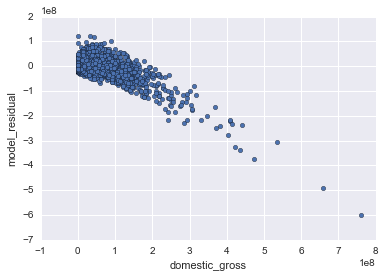

In [51]:
buildX['model_residual']=simplified_model.predict(buildX)-buildX['domestic_gross']
buildX['model_prediction']=simplified_model.predict(buildX)
buildX.plot(kind='scatter',x='domestic_gross', y='model_residual')

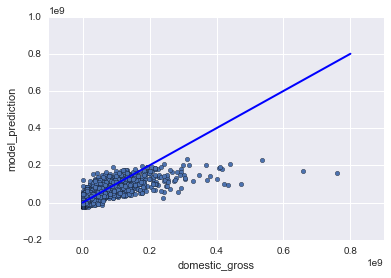

In [53]:
buildX.plot(kind='scatter',x='domestic_gross', y='model_prediction')
plt.plot([0, 800000000], [0, 800000000], 'b-', lw=2)

# Visualization of key insights

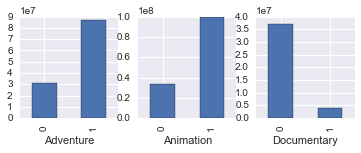

In [49]:
import matplotlib.pyplot as plt
plt.subplot(2,3,1)
both_df.groupby('Adventure')['domestic_gross'].mean().plot(kind='bar')
plt.subplot(2,3,2)
both_df.groupby('Animation')['domestic_gross'].mean().plot(kind='bar')
plt.subplot(2,3,3)
both_df.groupby('Documentary')['domestic_gross'].mean().plot(kind='bar')

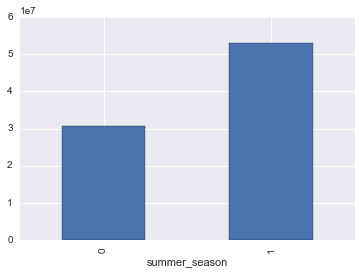

In [41]:
buildX.groupby('summer_season')['domestic_gross'].mean().plot(kind='bar')

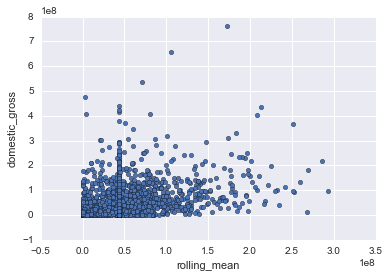

In [43]:
buildX.plot(kind='scatter',x='rolling_mean', y='domestic_gross')

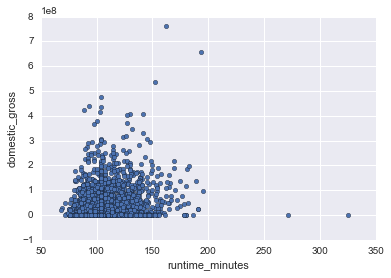

In [44]:
buildX.plot(kind='scatter',x='runtime_minutes', y='domestic_gross')

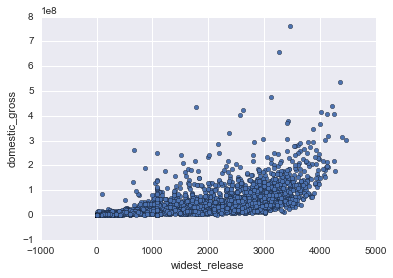

In [50]:
buildX.plot(kind='scatter',x='widest_release', y='domestic_gross')